https://github.com/mrzjy/sunburst

# Pip install vncorenlp



In [ ]:
pip install vncorenlp

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 27.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for vncorenlp: filename=vncorenlp-1.0.3-py3-none-any.whl size=2645950 sha256=f02b2a67fabaadb405a2bb3a613d0703027232e37531938145371aafe840338b
  Stored in directory: /root/.cache/pip/wheels/3c/e9/86/706911c12e307aeb9a2702399f0dad38d36f1d6f9dde8af35e
Successfully built vncorenlp


In [ ]:
!mkdir -p vncorenlp/models/wordsegmenter
!wget https://raw.githubusercontent.com/vncorenlp/VnCoreNLP/master/VnCoreNLP-1.1.1.jar
!mv VnCoreNLP-1.1.1.jar vncorenlp/

!wget https://raw.githubusercontent.com/vncorenlp/VnCoreNLP/master/models/wordsegmenter/vi-vocab
!wget https://raw.githubusercontent.com/vncorenlp/VnCoreNLP/master/models/wordsegmenter/wordsegmenter.rdr
!mv vi-vocab vncorenlp/models/wordsegmenter/
!mv wordsegmenter.rdr vncorenlp/models/wordsegmenter/


!mkdir -p vncorenlp/models/postagger
!wget https://raw.githubusercontent.com/vncorenlp/VnCoreNLP/master/models/postagger/vi-tagger 
!mv vi-tagger vncorenlp/models/postagger/


!mkdir -p vncorenlp/models/ner
!wget https://raw.githubusercontent.com/vncorenlp/VnCoreNLP/master/models/ner/vi-500brownclusters.xz
!wget https://raw.githubusercontent.com/vncorenlp/VnCoreNLP/master/models/ner/vi-ner.xz 
!wget https://raw.githubusercontent.com/vncorenlp/VnCoreNLP/master/models/ner/vi-pretrainedembeddings.xz
!mv vi-500brownclusters.xz vncorenlp/models/ner/
!mv vi-ner.xz vncorenlp/models/ner/
!mv vi-pretrainedembeddings.xz vncorenlp/models/ner/

--2023-02-12 15:03:48--  https://raw.githubusercontent.com/vncorenlp/VnCoreNLP/master/VnCoreNLP-1.1.1.jar
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 27412575 (26M) [application/octet-stream]
Saving to: ‘VnCoreNLP-1.1.1.jar’

VnCoreNLP-1.1.1.jar 100%[===================>]  26.14M  98.3MB/s    in 0.3s    

2023-02-12 15:03:50 (98.3 MB/s) - ‘VnCoreNLP-1.1.1.jar’ saved [27412575/27412575]

--2023-02-12 15:03:51--  https://raw.githubusercontent.com/vncorenlp/VnCoreNLP/master/models/wordsegmenter/vi-vocab
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting respo

In [ ]:
from vncorenlp import VnCoreNLP

vncorenlp = VnCoreNLP("vncorenlp/VnCoreNLP-1.1.1.jar", annotators="wseg") 

# Build graph 

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import argparse
import logging


# In[]: argument
def parse_hparams():
    parser = argparse.ArgumentParser(description='hparams')
    # parser.add_argument('-read', help='read from', default="example.txt")
    parser.add_argument('-ngram', help='ngram', type=int, default=2)
    parser.add_argument('-max_display_num', help='max number of ngrams to display', 
                        type=int, default=4)
    parser.add_argument('-min_count', help='min word occurence', 
                        type=int, default=1)
    parser.add_argument('-adjust_value', help='adjust node value for better visulization', 
                        type=int, default=1)
    parser.add_argument('-adjust_ratio', help='the total ratio taken up by child nodes', 
                        type=float, default=0.5)
    
    parser.add_argument('-f')
    args = parser.parse_args()
    return args


# read file
class readlines_iterative(object):
    def __init__(self, corpora_file):
        self.corpora_file = corpora_file
        
    def __iter__(self):
        for line in open(self.corpora_file, 'r', encoding='utf-8'): 
            yield line.strip()


# In[]: save ngrams through Trie structure
class Trie:
    def __init__(self, args):
        self.root = ['', 1, 'white', []]
        self.cmap = plt.get_cmap("tab20") # there are 20 colors at maximum
        self.max_display_num = args.max_display_num
        self.min_word_count = args.min_count
        logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
        self.logger = logging.getLogger(__name__)
    
    def insert(self, words:list) -> None: # Inserts a word into the trie
        """ Trie insertion """
        curNode = self.root
        for word in words:
            idx, already_contain = isInSubnodes(word, curNode)
            if not already_contain:
                curNode[-1].append([word, 1, [], []])
            else:
                curNode[-1][idx][1] += 1
            curNode = curNode[-1][idx]

    def prune(self, adjust_value=True, adjust_ratio=0.9):
        """ 
        prune based on max_display_num and min_count
        Args:
            adjust_value: if True, adjust node value for better visulization
            adjust_ratio: value within [0,1], the total ratio taken up by child nodes
        
        """
        self.logger.info('\tpruning')
        def recursive(node):
            if len(node[-1]) == 0:
                return
            
            subnodes = node[-1]
            subnodes = sorted(subnodes, key=lambda x: -x[1])[:self.max_display_num]
            subnodes = [n for n in subnodes if n[1] >= self.min_word_count]
            
            # re-assign subnode value for better visualization: 
            # subnode values sum up to adjust_ratio of father_value
            if adjust_value:
                father_value = node[1] * adjust_ratio
                subnode_values = [subnode[1] for subnode in subnodes]
                for subnode in subnodes:
                    subnode[1] = father_value * subnode[1]/sum(subnode_values)
            
            node[-1] = subnodes
            for subnode in node[-1]:
                recursive(subnode)
        
        recursive(self.root)
    
    def assign_node_color(self):
        """ assign node color """
        self.logger.info('\tcolorizing')
        def recursive(node, father_color):
            if not node:
                return
            
            node[2] = father_color
            for subNode in node[-1]:
                recursive(subNode, father_color)

        numNode_level_1 = len(self.root[-1])
        colors = self.cmap(range(numNode_level_1)).tolist()

        for idx, subnode_level_1 in enumerate(self.root[-1]):
            # assign father node color
            subnode_level_1[2] = colors[idx]
            # assign child node color
            recursive(subnode_level_1, colors[idx])

    def postprocess(self):
        self.logger.info('postprocessing')
        # assign root value
        root_value = 0
        for subnode in self.root[-1]:
            root_value += subnode[1]
        self.root[1] = root_value
        
        # prune and colorize
        self.prune()
        self.assign_node_color()
        

def isInSubnodes(word, node):
    for i,subnode in enumerate(node[-1]):
        if word == subnode[0]:
            return i, True
    return -1, False


def computeNgramTrie(args, sentences: list, n: int=3, deliminator=" ") -> list:
    all_ngrams = Trie(args)
    preprocess_func = lambda l: l.split(deliminator) if deliminator else l
    all_ngrams.logger.info("constructing ngram Trie")
    for sentence in sentences:
        sentence = preprocess_func(sentence)
        ngrams = [sentence[i:i+n] for i in range(len(sentence)-n+1)]
        for ngram in ngrams:
            all_ngrams.insert(ngram)
    
    all_ngrams.postprocess()
    return all_ngrams


# In[]: visualization
def sunburst(nodes, total=np.pi * 2, offset=0, level=0, max_level=3, ax=None):
    """ 
    This elegant recursive sunburst comes from: 
        https://stackoverflow.com/questions/12926779/how-to-make-a-sunburst-plot-in-r-or-python
    Thanks for the author.
    """
    ax = ax or plt.subplot(111, projection='polar')
    
    if level > max_level:
        return
    
    if level == 0:
        label, value, _, subnodes = nodes
        ax.bar([0], [0.5], [np.pi * 2], color='white')
        ax.text(0, 0, label, ha='center', va='center', size=30)
        sunburst(subnodes, total=value, ax=ax,
                 level=level + 1, max_level=max_level)
    elif nodes:        
        d = np.pi * 2 / total
        labels = []
        widths = []
        colors = []
        local_offset = offset
        
        for label, value, color, subnodes in nodes:
            labels.append(label)
            widths.append(value * d)
            colors.append(color)
            sunburst(subnodes, total=total, offset=local_offset,
                     level=level + 1, max_level=max_level, ax=ax)
            local_offset += value

        values = np.cumsum([offset * d] + widths[:-1])
        heights = [1] * len(nodes)
        bottoms = np.zeros(len(nodes)) + level - 0.5
        rects = ax.bar(values, heights, widths, bottoms, linewidth=1,
                       color=colors, edgecolor='white', align='edge')
        for rect, label in zip(rects, labels):
            x = rect.get_x() + rect.get_width() / 2
            y = rect.get_y() + rect.get_height() / 2
            rotation = (90 + (360 - np.degrees(x) % 180)) % 360
            ax.text(x, y, label, rotation=rotation, ha='center', va='center') 

    if level == 0:
        ax.set_theta_direction(-1)
        ax.set_theta_zero_location('N')
        ax.set_axis_off()

# Analyst the question types

In [ ]:
vimmrc2 = 'drive/MyDrive/CODE/ViMMRC/dataset/race_ver_2/dev_race.json'
vimmrc1 = 'drive/MyDrive/CODE/ViMMRC/dataset/race_ver_1/dev_race.json'

viquad = 'drive/MyDrive/CODE/ViMMRC/dataset/viquad/dev_ViQuAD.json'

In [1]:
import json

with open(vimmrc2, 'r') as f:
    VIMMRC2 = json.load(f, encoding='utf8')

with open(vimmrc1, 'r') as f:
    VIMMRC1 = json.load(f, encoding='utf8')

with open(viquad, 'r') as f:
    VIQUAD = json.load(f, encoding='utf8')

NameError: ignored

In [ ]:
list_question_2 = []
list_question_1 = []
list_viquad = []

for r in VIMMRC2:
    for q in r['questions']:
        list_question_2.append(' '.join(s for s in vncorenlp.tokenize(q)[0]))
    # list_question_2 = list_question_2 + r['questions']

for r in VIMMRC1:
    for q in r['questions']:
        list_question_1.append(' '.join(s for s in vncorenlp.tokenize(q)[0]))
    # list_question_1 = list_question_1 + r['questions']

for r in VIQUAD['data']:
    for q in r['paragraphs']:
        for qa in q['qas']:
            # list_viquad.append(qa['question'])
            list_viquad.append(' '.join(s for s in vncorenlp.tokenize(qa['question'])[0]))

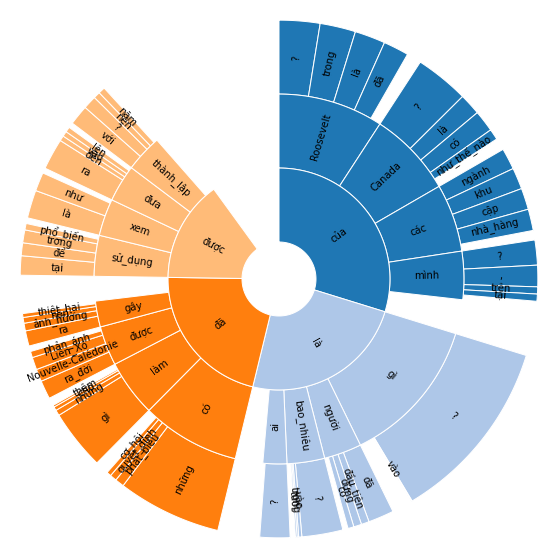

In [ ]:
if __name__ == '__main__':
    # # args
    args = parse_hparams()
    
    # read file
    # texts = readlines_iterative(args.read)
    texts = list_viquad

    n_gram = 3

    # generate ngram
    ngramTrie = computeNgramTrie(args, texts, n=n_gram, deliminator=" ")
    
    # plot sunburst
    plt.figure(figsize=(10,10)) # should be large for readability
    sunburst(ngramTrie.root, max_level=n_gram+1)
    
    # save
    # plt.savefig('viquad_trigram.png', format='png', dpi=250)

# By types

In [ ]:
quest_type_full = 'drive/My Drive/CODE/ViMMRC/dev_question_types_full.csv'

In [ ]:
import pandas as pd

type_questions = pd.read_csv(quest_type_full)

In [ ]:
lst_types = type_questions.loc[type_questions['types'] == 4]['questions'].tolist()

new_lst_type = []
for q in lst_types:
    new_lst_type.append(' '.join(s for s in vncorenlp.tokenize(q)[0]))

lst_types = new_lst_type

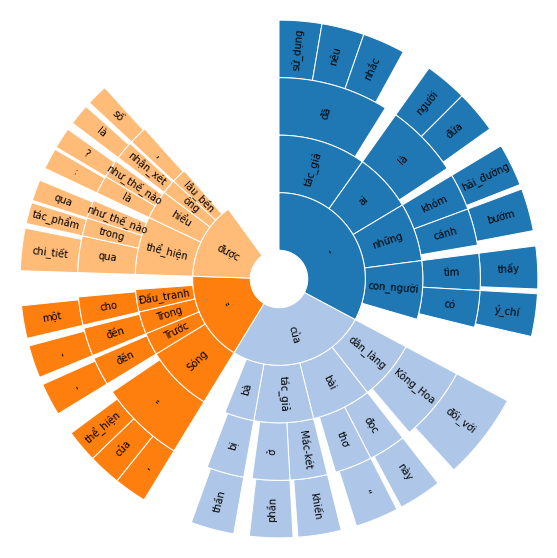

In [ ]:
if __name__ == '__main__':
    # # args
    args = parse_hparams()
    
    # read file
    # texts = readlines_iterative(args.read)
    texts = lst_types

    n_gram = 4

    # generate ngram
    ngramTrie = computeNgramTrie(args, texts, n=n_gram, deliminator=" ")
    
    # plot sunburst
    plt.figure(figsize=(10,10)) # should be large for readability
    sunburst(ngramTrie.root, max_level=n_gram+1)
    
    # save
    # plt.savefig('viquad_trigram.png', format='png', dpi=250)